# Multistep time series forcasting using Keras and Tensorflow2

#### This notebook is inspired by 
https://www.kaggle.com/code/nicapotato/keras-timeseries-multi-step-multi-output/notebook

Weather time series dataset recorded by the Max Planck Institute of Biochemistry


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys


In [3]:
mpl.rcParams['figure.figsize']=(17, 5)
mpl.rcParams['axes.grid']=False
sns.set_style("whitegrid")
notebookstart=time.time()


In [4]:
# Defind parameters to load data
batch_size = 256
buffer_size = 10000
train_split = 300000

#LSTM parameters
evaluation_interval =200
epochs=4
patience = 5

#reproducibility
seed = 42
tf.random.set_seed(seed)


In [5]:
zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
                                   fname='jena_climate_2009_2016.csv.zip',
                                   extract=True)
csv_path, _ =os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
print("Dataframe Shape : {} rows, {} columns".format(*df.shape))
display(df.head())

13582336/13568290 [==============================] - 0s 0us/step
Dataframe Shape : 420551 rows, 15 columns


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
# Define function to get past window of information and future steps to predict
#history_size= size of the past window
#target_size= how far in the future does the model needs to predict

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset)- target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(np.reshape(dataset[indices],(history_size,1)))
    labels.append(dataset[i+target_size])
  
  return np.array(data), np.array(labels)

  

In [7]:
# Univariate time series forecast
# Train model using only a single feature and use it to forcast for that value in future

uni_data=df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

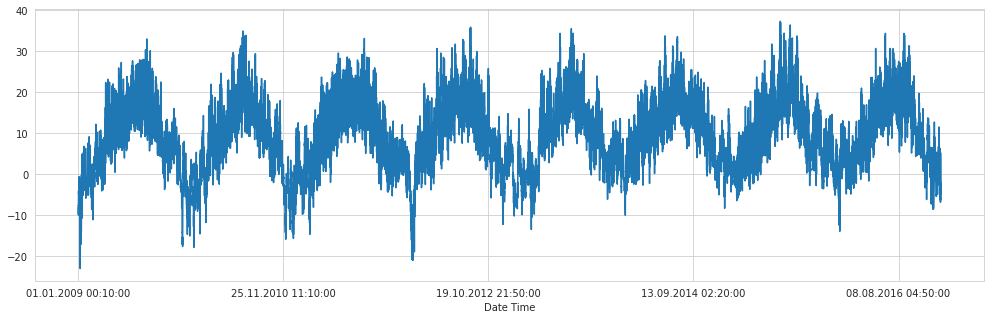

In [8]:
uni_data.plot(subplots=True)
plt.show()
uni_data = uni_data.values

In [9]:
# standardize the features
uni_train_mean = uni_data[:train_split].mean()
uni_train_std = uni_data[:train_split].std()
uni_data= (uni_data-uni_train_mean)/uni_train_std
print(uni_data[0])

-1.9976629443608853


In [10]:
# Create the data for univariate model. The model will be given last 20 values of temperature
#and needs to learn to prdict the next time step.

univariate_past_history=20
univariate_future_target=0

x_train_uni, y_train_uni = univariate_data(dataset=uni_data, start_index=0,
                                           end_index=train_split,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=train_split,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

print("IN:")

print(uni_data.shape)
print(uni_data[:5])

print("\nOut:")
print(x_train_uni.shape)

print(x_train_uni.shape[0]/uni_data.shape[0])

IN:
(420551,)
[-1.99766294 -2.04281897 -2.05439744 -2.0312405  -2.02660912]

Out:
(299980, 20, 1)
0.7133023105402199


In [11]:
print('Single window of past history.shape: {}'.format(x_train_uni[0].shape))
print(x_train_uni[0])
print('\n target temperature to predict.Shape : {}'.format(y_train_uni[0].shape))
print(y_train_uni[0])

Single window of past history.shape: (20, 1)
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 target temperature to predict.Shape : ()
-2.1041848598100876


In [12]:
def create_time_steps(length):
  return list(range(-length, 0))

In [13]:
def show_plot(plot_data, delta, title):
  labels = ['History' ,'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']

  time_steps =create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future=0
  
  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(),marker[i],label=labels[i])

      plt.legend()
      plt.xlim([time_steps[0],(future+5)*2])
      plt.xlabel('Time-step')
    return plt




<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

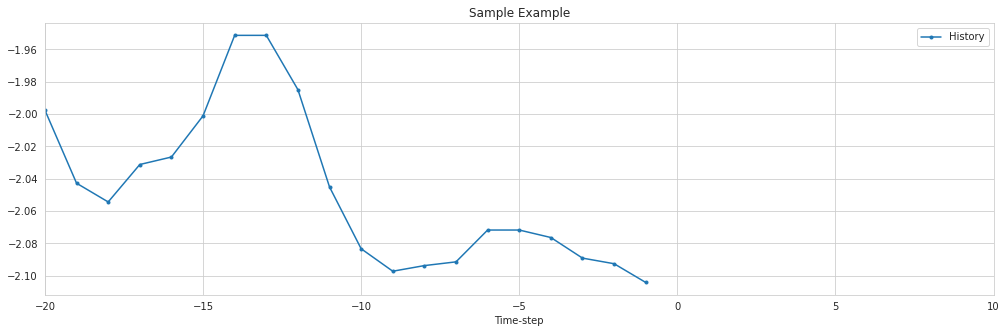

In [14]:
show_plot([x_train_uni[0], y_train_uni[0]],0, 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

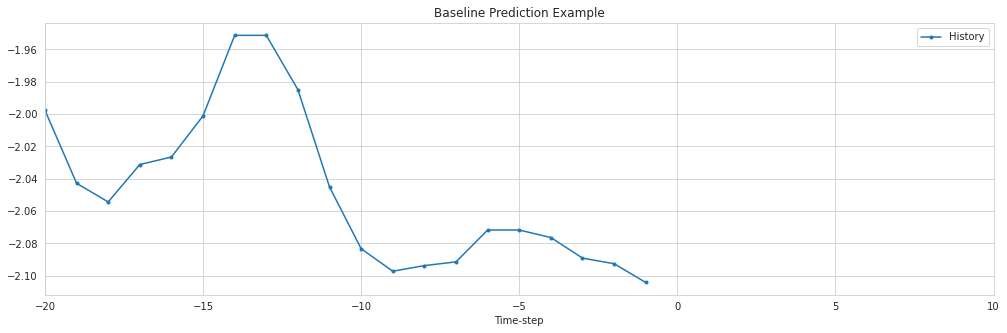

In [15]:
#Baseline- mean of last 2o obs

def baseline(history):
  return np.mean(history)

show_plot([x_train_uni[0],y_train_uni[0],baseline(x_train_uni[0])],0,'Baseline Prediction Example')

In [16]:
#LSTM predictions

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(batch_size).repeat()

In [17]:
x_train_uni.shape

(299980, 20, 1)

In [18]:
#Simple LSTM model
simple_lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(8,input_shape = x_train_uni.shape[-2:]),
                                                tf.keras.layers.Dense(1)])
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [19]:
# Check output of the model
for x, y in val_univariate.take(1):
  print(simple_lstm_model.predict(x).shape)

(256, 1)


In [20]:
# Due to the large size of data lets define early stopping call back to run for few steps only

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
simple_lstm_model.fit(train_univariate,
                      epochs=epochs,
                      steps_per_epoch=evaluation_interval,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

Epoch 1/4
200/200 [==============================] - 5s 16ms/step - loss: 0.3429 - val_loss: 0.0544
Epoch 2/4
200/200 [==============================] - 3s 14ms/step - loss: 0.0754 - val_loss: 0.0268
Epoch 3/4
200/200 [==============================] - 3s 13ms/step - loss: 0.0393 - val_loss: 0.0222
Epoch 4/4
200/200 [==============================] - 3s 13ms/step - loss: 0.0383 - val_loss: 0.0197


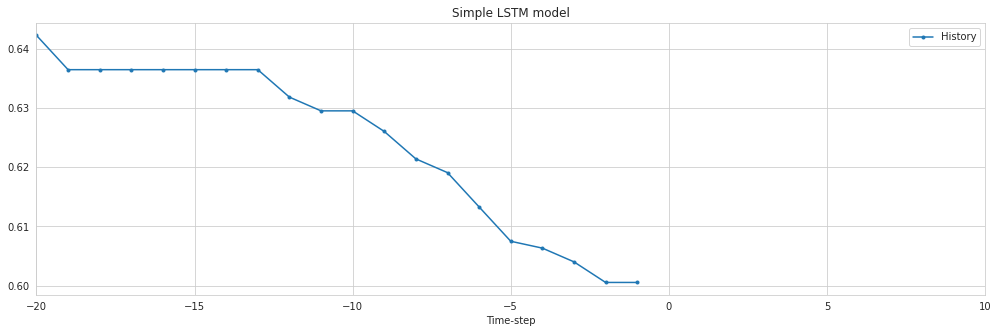

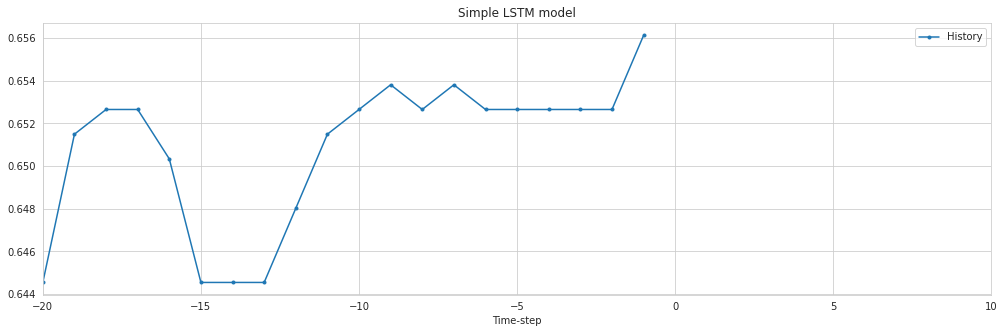

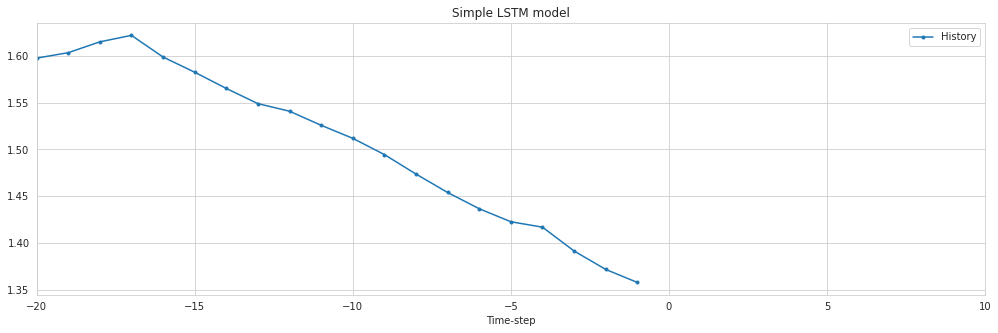

In [21]:
#predict using simple LSTM model

for x, y in val_univariate.take(3):
  plot=show_plot([x[0].numpy(),y[0].numpy(),simple_lstm_model.predict(x)[0]],0,'Simple LSTM model')
  plt.show()

In [22]:
# delete single variable model so that we can work on multivariate time series
del simple_lstm_model, train_univariate, val_univariate

In [23]:
# Multivariate time series
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index=df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a89987a90>,
      dtype=object)

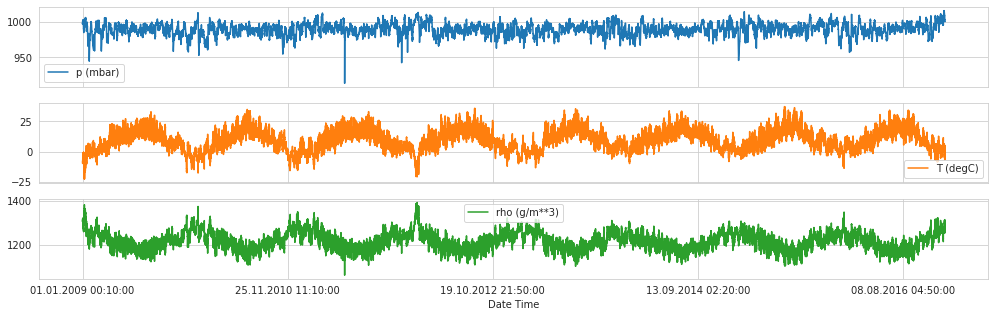

In [24]:
features.plot(subplots=True)

In [26]:
dataset = features.values
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)
dataset= (dataset-data_mean)/data_std

In [27]:
display(pd.DataFrame(dataset, columns=features.columns, index=features.index).head())

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,0.955474,-1.997663,2.235079
01.01.2009 00:20:00,0.961545,-2.042819,2.285240
01.01.2009 00:30:00,0.956688,-2.054397,2.296006
01.01.2009 00:40:00,0.954259,-2.031241,2.270314
01.01.2009 00:50:00,0.954259,-2.026609,2.265665


In [30]:
#Single step forecast for multivariate time series
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size,step, single_step=False):
  data =[]
  labels = []
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset)- target_size
  for i in range(start_index, end_index):
    indices=range(i-history_size, i, step)
    data.append(dataset[indices])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  return np.array(data), np.array(labels)


In [32]:
past_history = 720
future_target = 72
step =6
x_train_single, y_train_single =multivariate_data(dataset, dataset[:,1],0,train_split,past_history,future_target,step,single_step=True)
x_val_single, y_val_single = multivariate_data(dataset,dataset[:,1],train_split,None,past_history,future_target,step,single_step=True)

print(x_train_single.shape)
print('Single window of past history :{}'.format(x_train_single[0].shape))
print(x_train_single.shape[-2:])

(299280, 120, 3)
Single window of past history :(120, 3)
(120, 3)


In [33]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(batch_size).repeat()

In [36]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape =x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [37]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [40]:
print(f"Evaluation Threshold: {evaluation_interval}", f"Epochs: {epochs}", sep ="\n")
early_stopping = EarlyStopping(monitor='val_loss', patience =3, restore_best_weights=True)
single_step_history = single_step_model.fit(train_data_single, epochs=epochs, steps_per_epoch=evaluation_interval, validation_data=val_data_single, callbacks=[early_stopping], validation_steps=50)

Evaluation Threshold: 200
Epochs: 4
Epoch 1/4
200/200 [==============================] - 33s 129ms/step - loss: 0.3084 - val_loss: 0.2530
Epoch 2/4
200/200 [==============================] - 23s 115ms/step - loss: 0.2636 - val_loss: 0.2357
Epoch 3/4
200/200 [==============================] - 23s 116ms/step - loss: 0.2599 - val_loss: 0.2395
Epoch 4/4
200/200 [==============================] - 25s 127ms/step - loss: 0.2566 - val_loss: 0.2441


In [41]:
def plot_train_history(history, title):
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs= range(len(loss))
  plt.figure()
  plt.plot(epochs, loss,'b',label='TrainingLoss')
  plt.plot(epochs,val_loss,'r',label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.show()

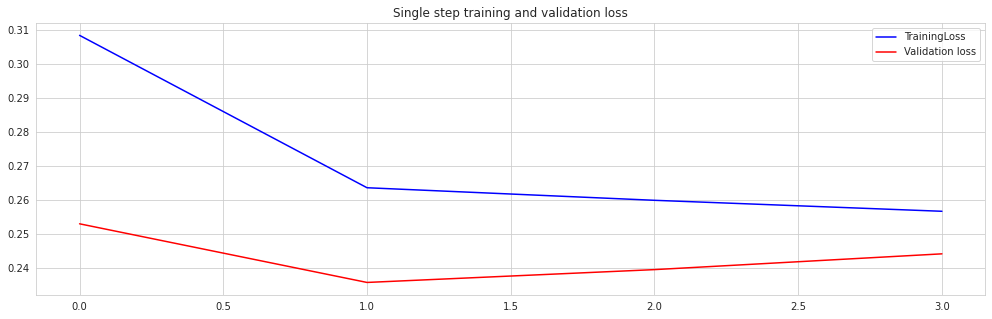

In [42]:
plot_train_history(single_step_history, 'Single step training and validation loss')

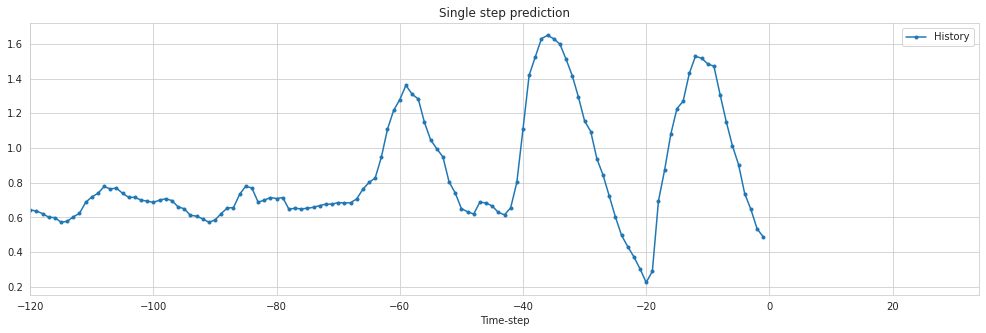

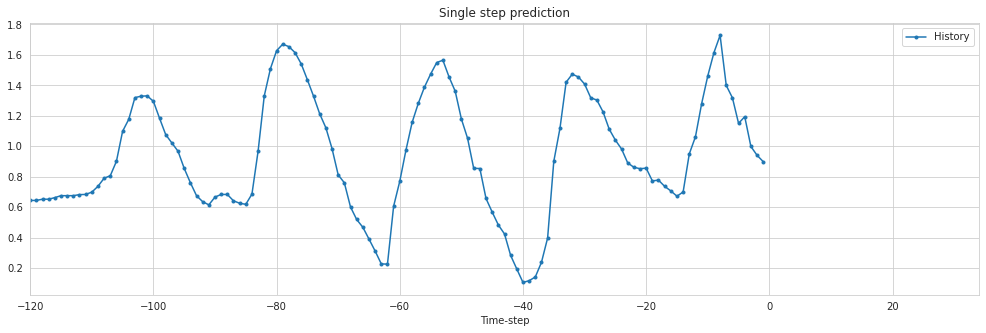

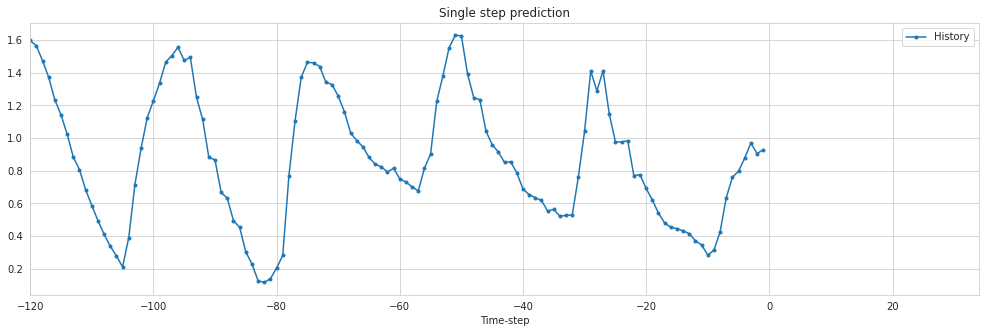

In [43]:
#predict a single step future
for x, y in val_data_single.take(3):
  plot= show_plot([x[0][:,1].numpy(),y[0].numpy(),single_step_model.predict(x)[0]],12,'Single step prediction')
  plt.show()

In [ ]:
# Multi step model

## Multi step model




In [44]:
past_history =720
future_target=72
step=6

x_train_multi, y_train_multi=multivariate_data(dataset, dataset[:,1],0,train_split,past_history,future_target,step)
x_val_multi, y_val_multi= multivariate_data(dataset, dataset[:,1],train_split,None, past_history,future_target,step)

In [45]:
#lets check out the sample
print(x_train_multi.shape, y_train_multi.shape,
      'Single window of past history: {}'.format(x_train_multi[0].shape),'Target temperature to predict :{}'.format(y_train_multi[0].shape),sep='\n')

(299280, 120, 3)
(299280, 72)
Single window of past history: (120, 3)
Target temperature to predict :(72,)


In [47]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi,y_train_multi))
train_data_multi= train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

In [52]:
def multi_step_plot(history, true_future,prediction):
  plt.figure(figsize=(18,6))
  num_in=create_time_steps(len(history))
  num_out=len(true_future)
  plt.plot(num_in, np.array(history[:,1]),label='History')
  plt.plot(np.arange(num_out)/step,np.array(true_future),'bo',label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/step, np.array(prediction),'ro',label="Predicted Future")
    plt.legend(loc='upper left')
    plt.show()

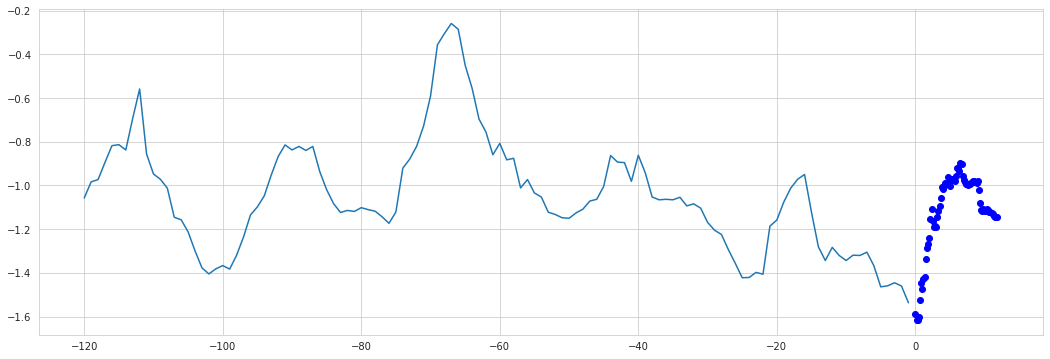

In [53]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0],y[0],np.array([0]))

In [54]:
# Since the task is bit more complicated, model now consists of two LSTM layers,since 72 predictions are made, dense layer has 72 outputs

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True,input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16,activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),loss='mae')

print(multi_step_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 120, 32)           4608      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 72)                1224      
                                                                 
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
for x,y in val_data_multi.take(1):
  print(multi_step_model.predict(x).shape)
  

(256, 72)


In [57]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=epochs,
                                          steps_per_epoch=evaluation_interval,
                                          validation_data=val_data_multi,
                                          validation_steps=evaluation_interval,
                                          callbacks=[early_stopping])

Epoch 1/4
200/200 [==============================] - 56s 251ms/step - loss: 231.2005 - val_loss: 0.5895
Epoch 2/4
200/200 [==============================] - 54s 271ms/step - loss: 0.4595 - val_loss: 0.3837
Epoch 3/4
200/200 [==============================] - 50s 248ms/step - loss: 0.3693 - val_loss: 0.3433
Epoch 4/4
200/200 [==============================] - 49s 247ms/step - loss: 0.2828 - val_loss: 0.2572


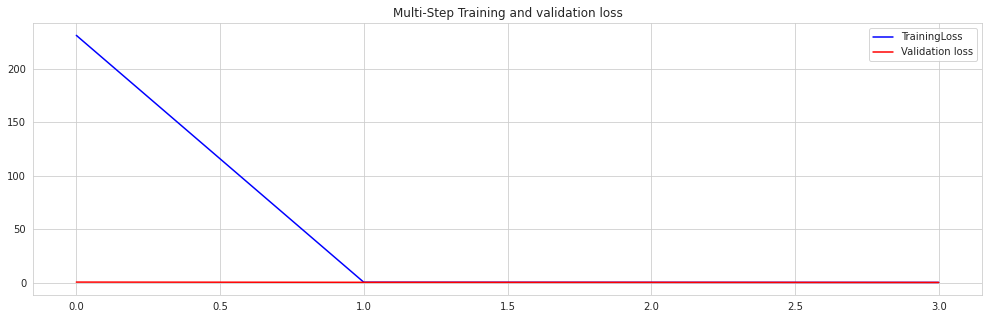

In [58]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

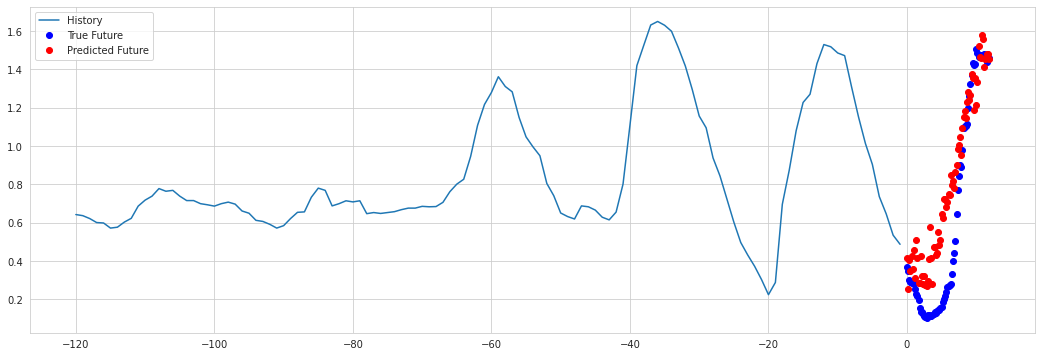

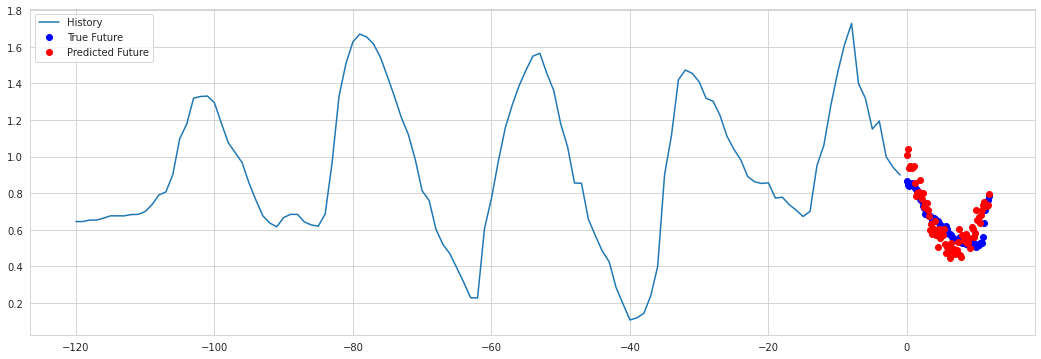

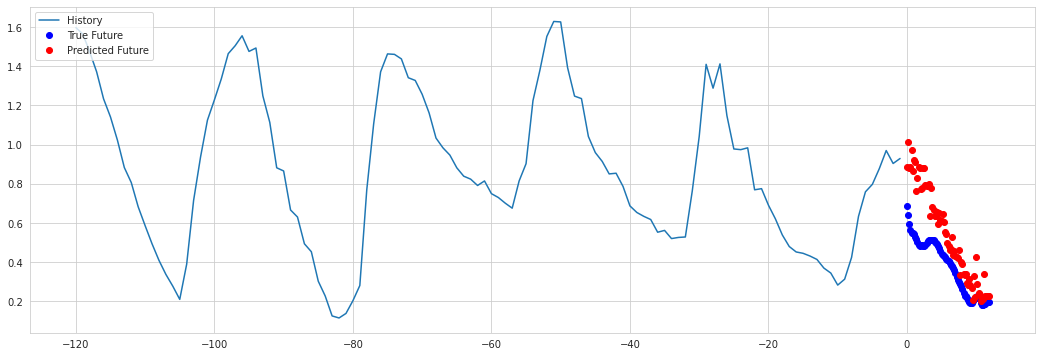

In [59]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])